In [1]:
%pip install kaggle==1.5.12 tensorflow scikit-learn pandas matplotlib seaborn opencv-python pathlib numpy
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d proutkarshtiwari/adni-images-for-alzheimer-detection -p /content/ --unzip
# print("Kaggle dataset downloaded and unzipped (if uncommented).")


[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [9]:
# Cell 1: Setup and Imports
# ==========================

# --- Optional: Kaggle Setup (Uncomment if running on Kaggle/downloading) ---
# !pip install kaggle==1.5.12 tensorflow scikit-learn pandas matplotlib seaborn opencv-python pathlib numpy
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d proutkarshtiwari/adni-images-for-alzheimer-detection -p /content/ --unzip
# print("Kaggle dataset downloaded and unzipped (if uncommented).")

# --- Standard Imports ---
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from pathlib import Path
from collections import Counter
import time  # To time operations

# --- Scikit-learn Imports ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.utils import class_weight # No longer needed for balanced data

# --- TensorFlow Imports ---
import tensorflow as tf
from tensorflow.keras import layers, models, applications, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model

print("--- Imports completed ---")
print(f"TensorFlow Version: {tf.__version__}")

--- Imports completed ---
TensorFlow Version: 2.18.0


In [18]:
# Cell 2: Configuration
# ======================
print("--- Configuring Paths and Parameters ---")

# --- Environment Setup ---
# << IMPORTANT >>: SET THESE PATHS ACCORDING TO YOUR ENVIRONMENT
# Kaggle Example: BASE_INPUT_DIR = '/kaggle/input/adni-images-for-alzheimer-detection'
# Colab Example: BASE_INPUT_DIR = '/content/adni-images-for-alzheimer-detection'
# Local Example: BASE_INPUT_DIR = 'C:/Users/YourUser/Downloads/adni-images-for-alzheimer-detection'
BASE_INPUT_DIR = '/Users/daveboku/Desktop/Classes/ANN:DL/AD-detection/ADNI_IMAGES'

# Colab Example (Drive): MODEL_SAVE_DIR = '/content/drive/MyDrive/AD_Models'
# Kaggle Example: MODEL_SAVE_DIR = '/kaggle/working/'
# Local Example: MODEL_SAVE_DIR = './adni_models'
MODEL_SAVE_DIR = './adni_model_kaggle' # Save in the current Colab/Kaggle directory

os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
print(f"Base Input Directory: {BASE_INPUT_DIR}")
print(f"Model Save Directory: {MODEL_SAVE_DIR}")

# --- Data Paths ---
CSV_PATH = os.path.join(BASE_INPUT_DIR, 'train.csv')
IMAGE_DIR_PARENT = os.path.join(BASE_INPUT_DIR) # Parent dir containing class folders
print(f"CSV Path: {CSV_PATH}")
print(f"Image Directory Parent: {IMAGE_DIR_PARENT}")

--- Configuring Paths and Parameters ---
Base Input Directory: /Users/daveboku/Desktop/Classes/ANN:DL/AD-detection/ADNI_IMAGES
Model Save Directory: ./adni_model_kaggle
CSV Path: /Users/daveboku/Desktop/Classes/ANN:DL/AD-detection/ADNI_IMAGES/train.csv
Image Directory Parent: /Users/daveboku/Desktop/Classes/ANN:DL/AD-detection/ADNI_IMAGES


In [15]:
# --- Model & Training Params ---
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 2
SEED = 42
INPUT_SHAPE = IMG_SIZE + (3,)

# Phase 1 (Feature Extraction / Head Training)
EPOCHS_PHASE1 = 15          # Adjust as needed, EarlyStopping might trigger sooner
LEARNING_RATE_PHASE1 = 1e-3 # Start with a standard LR for the head

# Phase 2 (Fine-tuning)
EPOCHS_PHASE2 = 30          # More epochs allowed, but rely on EarlyStopping
LEARNING_RATE_PHASE2 = 1e-5 # Much lower LR for fine-tuning

# Model Saving Paths
MODEL_CHECKPOINT_PATH = os.path.join(MODEL_SAVE_DIR, 'resnet50v2_adni_best.keras')
FINAL_MODEL_PATH = os.path.join(MODEL_SAVE_DIR, 'resnet50v2_adni_final.keras')
print(f"Best model checkpoint path: {MODEL_CHECKPOINT_PATH}")
print(f"Final model save path: {FINAL_MODEL_PATH}")

# --- Class Mapping ---
diagnosis_mapping = {
    # 0: 'CN', 1: 'MCI', 2: 'EMCI', 3: 'LMCI', 4: 'AD'
    0: 'CN', 4: 'AD'
}
class_names = list(diagnosis_mapping.values())
print(f"Class Names: {class_names}")

# --- Reproducibility ---
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
print(f"Seeds set to: {SEED}")

print("--- Configuration complete ---")

Best model checkpoint path: ./adni_model_kaggle/resnet50v2_adni_best.keras
Final model save path: ./adni_model_kaggle/resnet50v2_adni_final.keras
Class Names: ['CN', 'AD']
Seeds set to: 42
--- Configuration complete ---


In [16]:
# Cell 3: GPU Check
# ==================
print("\n--- GPU Check ---")
gpu_devices = tf.config.list_physical_devices('GPU')
print(f"Num GPUs Available: {len(gpu_devices)}")
if gpu_devices:
    print("GPU is available. TensorFlow should use it automatically.")
    try:
        for gpu in gpu_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(f"Could not set memory growth: {e}")
else:
    print("WARNING: No GPU detected. Training will be on CPU (might be very slow).")
print("--- GPU Check complete ---")


--- GPU Check ---
Num GPUs Available: 0
--- GPU Check complete ---



--- Loading and Exploring Metadata (EDA) ---
CSV loaded successfully from /Users/daveboku/Desktop/Classes/ANN:DL/AD-detection/ADNI_IMAGES/train.csv in 0.10 seconds.
Dataset shape: (8152, 2)

Dataset head:
   id_code  diagnosis
0  CN-1819          0
1  CN-4049          0
2  CN-2461          0
3  CN-1406          0
4  CN-1205          0

Checking for missing values...
id_code      0
diagnosis    0
dtype: int64
No missing values found in the metadata.

Added 'class_name' and 'diagnosis_str' columns.
   diagnosis class_name diagnosis_str
0          0         CN             0
1          0         CN             0
2          0         CN             0
3          0         CN             0
4          0         CN             0

Analyzing Class Distribution...


/var/folders/j_/n1nxgfl11_516cyc9ylk84y40000gn/T/ipykernel_60579/220129608.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


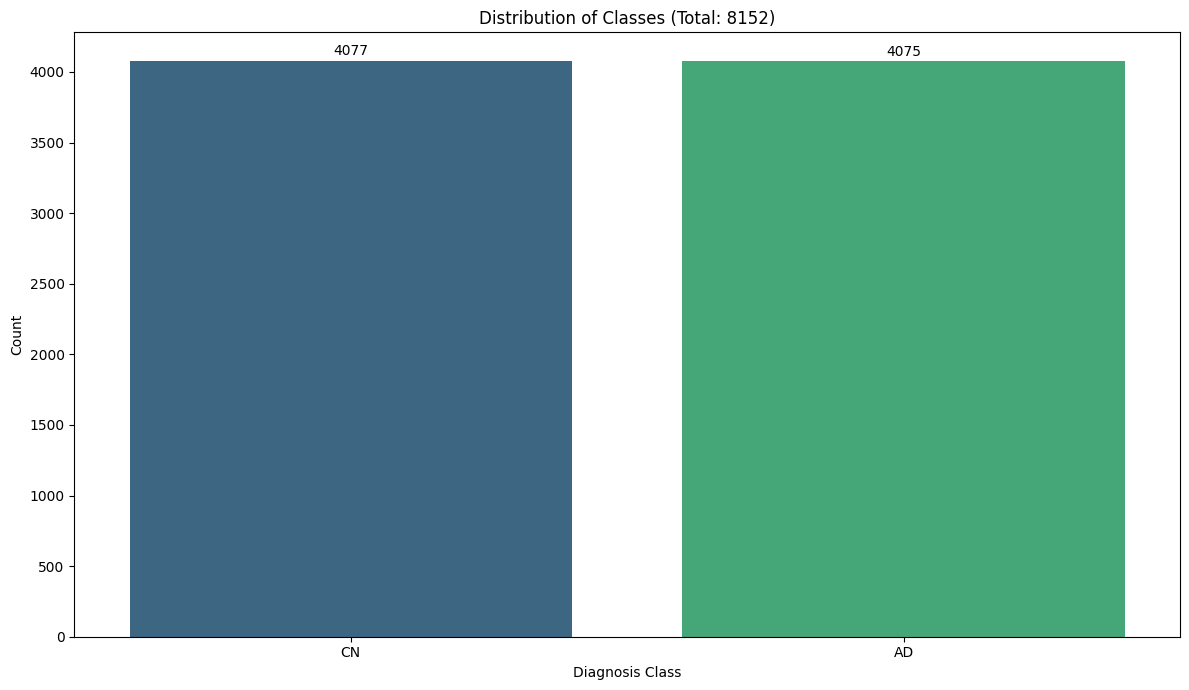


Exact Class Counts:
class_name
CN    4077
AD    4075
Name: count, dtype: int64

Min samples per class: 4075
Max samples per class: 4077
Dataset classes appear well-balanced.
Class weights will NOT be used.
--- EDA complete ---


In [17]:
# Cell 4: Load and Explore Metadata (EDA)
# =========================================
print("\n--- Loading and Exploring Metadata (EDA) ---")
df = None # Initialize df
try:
    start_time = time.time()
    df = pd.read_csv(CSV_PATH)
    end_time = time.time()
    print(f"CSV loaded successfully from {CSV_PATH} in {end_time - start_time:.2f} seconds.")
    print(f"Dataset shape: {df.shape}")
    print("\nDataset head:")
    print(df.head())
except FileNotFoundError:
    print(f"ERROR: CSV file not found at {CSV_PATH}")
    print("Please ensure the dataset path is correct in the Configuration cell.")
except Exception as e:
    print(f"An error occurred while loading the CSV: {e}")

if df is not None:
    print("\nChecking for missing values...")
    print(df.isnull().sum())
    if df.isnull().sum().sum() > 0:
        print("Warning: Missing values found!")
        # Add handling here if needed (e.g., df = df.dropna())
    else:
        print("No missing values found in the metadata.")

    # Map diagnosis codes to human-readable names and create string version
    df['class_name'] = df['diagnosis'].map(diagnosis_mapping)
    df['diagnosis_str'] = df['diagnosis'].astype(str) # For ImageDataGenerator y_col
    print("\nAdded 'class_name' and 'diagnosis_str' columns.")
    print(df[['diagnosis', 'class_name', 'diagnosis_str']].head())

    # --- Enhanced EDA: Class Distribution ---
    print("\nAnalyzing Class Distribution...")
    plt.figure(figsize=(12, 7))
    class_counts = df['class_name'].value_counts().loc[class_names] # Ensure order matches class_names
    sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
    plt.title(f"Distribution of Classes (Total: {len(df)})")
    plt.xlabel("Diagnosis Class")
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    # Add counts on top of bars
    for index, value in enumerate(class_counts.values):
        plt.text(index, value + 20, str(value), ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.show()

    print("\nExact Class Counts:")
    print(class_counts)
    # Check balance
    min_count = class_counts.min()
    max_count = class_counts.max()
    print(f"\nMin samples per class: {min_count}")
    print(f"Max samples per class: {max_count}")
    if max_count / min_count > 1.5: # Example threshold for imbalance
        print("Note: Some class imbalance detected, but seems relatively minor based on the plot.")
        print("Class weights will NOT be used as per the analysis.")
    else:
        print("Dataset classes appear well-balanced.")
        print("Class weights will NOT be used.")

else:
    print("\nDataFrame 'df' could not be loaded. Skipping further EDA and processing.")

print("--- EDA complete ---")

In [19]:
# Cell 5: Construct and Verify Image Paths
# ========================================
print("\n--- Constructing and Verifying Image Paths ---")
if df is not None:
    start_time = time.time()
    print("Constructing image paths...")
    df['image_path'] = df.apply(
        lambda row: os.path.join(IMAGE_DIR_PARENT, row['class_name'], f"{row['id_code']}.png"),
        axis=1
    )
    end_time = time.time()
    print(f"Image paths constructed in {end_time - start_time:.2f} seconds.")
    print("\nSample DataFrame with image paths:")
    print(df[['id_code', 'class_name', 'image_path']].head())

    # Verify paths (start with a sample)
    print("\nVerifying a sample of image paths...")
    num_to_check = min(200, len(df)) # Check a larger sample
    sample_paths = df['image_path'].sample(num_to_check, random_state=SEED)
    missing_samples = sample_paths[~sample_paths.apply(os.path.exists)]

    if not missing_samples.empty:
         print(f"WARNING: {len(missing_samples)} out of {num_to_check} sample image paths do not exist. Examples:")
         print(missing_samples.head())
         print("\nVerifying ALL paths (this might take time)...")
         start_time_full = time.time()
         path_exists = df['image_path'].apply(os.path.exists)
         missing_df = df[~path_exists]
         end_time_full = time.time()
         print(f"Full path verification took {end_time_full - start_time_full:.2f} seconds.")
         if not missing_df.empty:
             print(f"ERROR: Found {len(missing_df)} total missing image paths!")
             print("Example missing paths:")
             print(missing_df[['id_code', 'image_path']].head(10))
             # Raising error as missing images will break training
             raise FileNotFoundError(f"Missing image files found. Check IMAGE_DIR_PARENT: '{IMAGE_DIR_PARENT}' and CSV data integrity.")
         else:
            print("Full verification passed. All constructed image paths are valid.")
    else:
        print(f"All {num_to_check} sample image paths are valid.")
        # Assuming if a decent sample is valid, all are likely valid (can add full check if needed)
        # print("Assuming all paths are valid based on the sample check.")

else:
    print("DataFrame 'df' not loaded. Skipping path construction and verification.")

print("--- Path Verification complete ---")


--- Constructing and Verifying Image Paths ---
Constructing image paths...
Image paths constructed in 0.05 seconds.

Sample DataFrame with image paths:
   id_code class_name                                         image_path
0  CN-1819         CN  /Users/daveboku/Desktop/Classes/ANN:DL/AD-dete...
1  CN-4049         CN  /Users/daveboku/Desktop/Classes/ANN:DL/AD-dete...
2  CN-2461         CN  /Users/daveboku/Desktop/Classes/ANN:DL/AD-dete...
3  CN-1406         CN  /Users/daveboku/Desktop/Classes/ANN:DL/AD-dete...
4  CN-1205         CN  /Users/daveboku/Desktop/Classes/ANN:DL/AD-dete...

Verifying a sample of image paths...
All 200 sample image paths are valid.
--- Path Verification complete ---



--- Defining Image Preprocessing Function ---
Preprocessing function defined.

Testing preprocessing function...
Processing sample image: /Users/daveboku/Desktop/Classes/ANN:DL/AD-detection/ADNI_IMAGES/CN/CN-1819.png


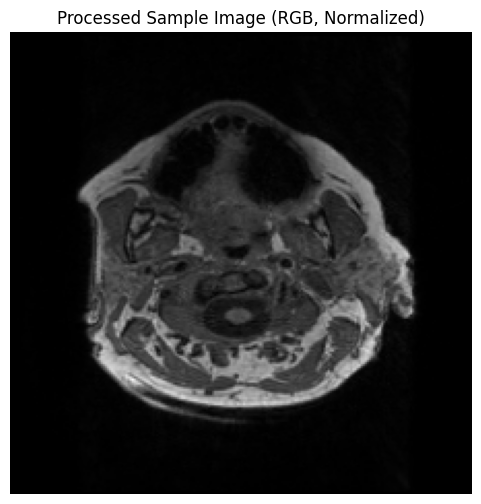

Processed image shape: (224, 224, 3)
Processed image min value: 0.0000
Processed image max value: 0.9765
Processed image dtype: float32
--- Preprocessing setup complete ---


In [21]:
# Cell 6: Image Preprocessing Function & Test
# ===========================================
print("\n--- Defining Image Preprocessing Function ---")
def preprocess_image(image_path, target_size=IMG_SIZE):
    """Reads, resizes, converts BGR->RGB, and normalizes image to [0, 1]."""
    try:
        img = cv2.imread(str(image_path)) # Ensure path is string
        if img is None:
            # print(f"Warning: Could not read image at {image_path}. Returning None.")
            return None
        img = cv2.resize(img, target_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Keras models expect RGB
        img = img.astype(np.float32) / 255.0 # Normalize to [0, 1]
        return img
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

print("Preprocessing function defined.")

# --- Test the function ---
print("\nTesting preprocessing function...")
if df is not None and not df.empty:
    # Find first path that actually exists, just in case of issues
    first_valid_path = None
    for path in df['image_path']:
        if os.path.exists(path):
            first_valid_path = path
            break

    if first_valid_path:
        print(f"Processing sample image: {first_valid_path}")
        sample_img_processed = preprocess_image(first_valid_path)
        if sample_img_processed is not None:
            plt.figure(figsize=(6, 6))
            plt.imshow(sample_img_processed)
            plt.title("Processed Sample Image (RGB, Normalized)")
            plt.axis('off')
            plt.show()
            print(f"Processed image shape: {sample_img_processed.shape}")
            print(f"Processed image min value: {sample_img_processed.min():.4f}")
            print(f"Processed image max value: {sample_img_processed.max():.4f}")
            print(f"Processed image dtype: {sample_img_processed.dtype}")
        else:
            print("Preprocessing failed for the sample image.")
    else:
        print("Could not find a valid image path in the dataframe to test preprocessing.")
else:
    print("DataFrame 'df' not available. Skipping preprocessing test.")

print("--- Preprocessing setup complete ---")

In [22]:
# Cell 7: Data Augmentation and Generators - CORRECTED
# =======================================
print("\n--- Setting up Data Augmentation and Generators ---")

# --- Augmentation Setup ---
train_datagen = ImageDataGenerator(
    rescale=1./255, # <<< ADD THIS LINE for normalization
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest',
    validation_split=0.2  # Use 20% of the data for validation (will be taken from df)
)
print("Train ImageDataGenerator configured with augmentation and rescaling.")

# Validation/Test generator only needs the split (no augmentation) and rescaling
validation_datagen = ImageDataGenerator(
    rescale=1./255, # <<< ADD THIS LINE for normalization
    validation_split=0.2
)
print("Validation/Test ImageDataGenerator configured (rescaling and validation_split).")


# --- Create Generators ---
train_generator = None
validation_generator = None
test_generator = None
class_weights_dict = None # Not needed for balanced data

if df is not None:
    print("\nCreating Train Generator...")
    start_time = time.time()
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=df,
        x_col='image_path',
        y_col='diagnosis_str', # Target labels as strings for categorical
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',      # Specify this subset
        shuffle=True,
        seed=SEED
    )
    end_time = time.time()
    # Correct the message about workers - they aren't directly set here
    print(f"Train Generator created in {end_time - start_time:.2f} seconds.")


    print("\nCreating Validation Generator...")
    start_time = time.time()
    validation_generator = validation_datagen.flow_from_dataframe(
        dataframe=df,
        x_col='image_path',
        y_col='diagnosis_str',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',    # Specify this subset
        shuffle=False,          # No shuffle for validation
        seed=SEED
    )
    end_time = time.time()
    print(f"Validation Generator created in {end_time - start_time:.2f} seconds.")

    print("\nCreating Test Generator (using validation subset)...")
    start_time = time.time()
    # Use the *same* generator object and parameters as validation for the test set
    test_generator = validation_datagen.flow_from_dataframe(
        dataframe=df,
        x_col='image_path',
        y_col='diagnosis_str',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE, # Keep same batch size for consistency in steps calculation
        class_mode='categorical',
        subset='validation',    # Use the same validation subset
        shuffle=False,          # No shuffle for testing
        seed=SEED
    )
    end_time = time.time()
    print(f"Test Generator created in {end_time - start_time:.2f} seconds.")

    # Verify generator outputs (optional but recommended)
    print("\nVerifying generator output shapes and types...")
    sample_batch_x, sample_batch_y = next(train_generator)
    print(f"Sample train batch X shape: {sample_batch_x.shape}")
    print(f"Sample train batch Y shape: {sample_batch_y.shape}")
    print(f"Sample train batch X dtype: {sample_batch_x.dtype}")
    print(f"Sample train batch Y dtype: {sample_batch_y.dtype}")
    # Now the min/max should reflect the rescaling
    print(f"Sample train batch X min/max: {sample_batch_x.min():.4f}/{sample_batch_x.max():.4f}")


    # --- Class Weights (REMOVED - Data is balanced) ---
    # print("\nClass weights are NOT being used as data is balanced.")
    class_weights_dict = None

else:
    print("DataFrame 'df' not loaded. Cannot create generators.")

print("--- Data Generators setup complete ---")


--- Setting up Data Augmentation and Generators ---
Train ImageDataGenerator configured with augmentation and rescaling.
Validation/Test ImageDataGenerator configured (rescaling and validation_split).

Creating Train Generator...
Found 6522 validated image filenames belonging to 2 classes.
Train Generator created in 0.06 seconds.

Creating Validation Generator...
Found 1630 validated image filenames belonging to 2 classes.
Validation Generator created in 0.03 seconds.

Creating Test Generator (using validation subset)...
Found 1630 validated image filenames belonging to 2 classes.
Test Generator created in 0.03 seconds.

Verifying generator output shapes and types...
Sample train batch X shape: (32, 224, 224, 3)
Sample train batch Y shape: (32, 2)
Sample train batch X dtype: float32
Sample train batch Y dtype: float32
Sample train batch X min/max: 0.0000/1.0000
--- Data Generators setup complete ---


In [23]:
# Cell 8: Build the Model (Two-Phase Ready)
# ==========================================
print("\n--- Building Model ---")

def build_resnet50v2_model(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES):
    """Builds a classification model using ResNet50V2 as the base."""
    print(f"Building model with input shape {input_shape} and {num_classes} classes.")
    # Load base model pre-trained on ImageNet
    print("Loading ResNet50V2 base model with ImageNet weights...")
    start_time = time.time()
    base_model = applications.ResNet50V2(
        weights='imagenet',
        include_top=False,     # Exclude the original ImageNet classifier head
        input_shape=input_shape
    )
    end_time = time.time()
    print(f"Base model loaded in {end_time - start_time:.2f} seconds.")

    # Build the full model
    inputs = tf.keras.Input(shape=input_shape, name='input_layer')
    # Set training=False for the base model initially (feature extraction phase)
    # This prevents BatchNorm layers from updating their statistics during this phase
    x = base_model(inputs, training=False)
    print("Base model added (initially frozen).")

    # Custom classification head
    print("Adding custom classification head...")
    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = layers.Dense(512, activation='relu', name='dense_head_1')(x)
    x = layers.BatchNormalization(name='batch_norm_head_1')(x)
    x = layers.Dropout(0.5, name='dropout_head_1')(x) # Regularization
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)
    print("Output layer added.")

    model = models.Model(inputs, outputs, name='alzheimer_resnet50v2')
    print("Model built successfully.")

    return model, base_model # Return both model and base_model reference

# Build the initial model
model, base_model = build_resnet50v2_model()

print("\n--- Initial Model Summary (Base Frozen) ---")
model.summary()
print("--- Model Building complete ---")


--- Building Model ---
Building model with input shape (224, 224, 3) and 2 classes.
Loading ResNet50V2 base model with ImageNet weights...
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Base model loaded in 7.54 seconds.
Base model added (initially frozen).
Adding custom classification head...
Output layer added.
Model built successfully.

--- Initial Model Summary (Base Frozen) ---


Model: "alzheimer_resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avg_pool                        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_head_1 (Dense)            │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_head_1               │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_head_1 (Dropout)        │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,616,962 (93.91 MB)

 Trainable params: 24,570,498 (93.73 MB)

 Non-trainable params: 46,464 (181.50 KB)

--- Model Building complete ---


In [24]:
# Cell 9: Compile and Train (Phase 1 - Head Training) - CORRECTED
# =====================================================
print("\n--- Training Phase 1: Feature Extraction (Train Head) ---")

# --- Configure Callbacks for Phase 1 ---
print("Configuring callbacks...")
# Use slightly different patience maybe, or reuse
early_stopping_p1 = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True) # Shorter patience for head
reduce_lr_p1 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=1e-6) # Allow slightly higher min_lr
model_checkpoint_p1 = ModelCheckpoint(MODEL_CHECKPOINT_PATH, monitor='val_accuracy', save_best_only=True, save_weights_only=False, verbose=1)

callbacks_phase1 = [early_stopping_p1, reduce_lr_p1, model_checkpoint_p1]
print("Callbacks configured for Phase 1.")

# --- Compile for Phase 1 ---
print("\nCompiling model for Phase 1...")
base_model.trainable = False # Ensure base is frozen
optimizer_phase1 = optimizers.Adam(learning_rate=LEARNING_RATE_PHASE1)
model.compile(
    optimizer=optimizer_phase1,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
print("Model compiled.")
print(f"Confirming base model trainable status: {base_model.trainable}")
print(f"Number of trainable weights in base model: {len(base_model.trainable_weights)}") # Should be 0

# --- Train Phase 1 ---
history_phase1 = None
if train_generator and validation_generator:
    print("\nStarting Phase 1 training...")
    start_time = time.time()
    history_phase1 = model.fit(
        train_generator,
        epochs=EPOCHS_PHASE1,
        validation_data=validation_generator,
        callbacks=callbacks_phase1,
        # class_weight=class_weights_dict, # REMOVED
        # REMOVE steps_per_epoch=max(1, train_generator.samples // BATCH_SIZE),
        # REMOVE validation_steps=max(1, validation_generator.samples // BATCH_SIZE)
        # Let Keras infer the steps from the generator length
    )
    end_time = time.time()
    print(f"--- Phase 1 training finished in {(end_time - start_time)/60:.2f} minutes ---")
else:
    print("Generators not available. Skipping Phase 1 training.")

print("--- Phase 1 complete ---")


--- Training Phase 1: Feature Extraction (Train Head) ---
Configuring callbacks...
Callbacks configured for Phase 1.

Compiling model for Phase 1...
Model compiled.
Confirming base model trainable status: False
Number of trainable weights in base model: 0

Starting Phase 1 training...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 975ms/step - accuracy: 0.5383 - loss: 1.0924
Epoch 1: val_accuracy improved from -inf to 0.11840, saving model to ./adni_model_kaggle/resnet50v2_adni_best.keras
204/204 ━━━━━━━━━━━━━━━━━━━━ 268s 1s/step - accuracy: 0.5383 - loss: 1.0917 - val_accuracy: 0.1184 - val_loss: 1.2732 - learning_rate: 0.0010
Epoch 2/15
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5746 - loss: 0.7386
Epoch 2: val_accuracy did not improve from 0.11840
204/204 ━━━━━━━━━━━━━━━━━━━━ 294s 1s/step - accuracy: 0.5746 - loss: 0.7386 - val_accuracy: 0.0920 - val_loss: 1.0287 - learning_rate: 0.0010
Epoch 3/15
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5948 - loss: 0.6954
Epoch 3: val_accuracy did not improve from 0.11840
204/204 ━━━━━━━━━━━━━━━━━━━━ 283s 1s/step - accuracy: 0.5947 - loss: 0.6954 - val_accuracy: 0.0706 - val_loss: 0.9852 - learning_rate: 0.0010
Epoch 4/15
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6079 - loss: 0.6798
Epoch 4: val_

In [26]:
# Cell 10: Compile and Train (Phase 2 - Fine-Tuning)
# ===================================================
print("\n--- Training Phase 2: Fine-Tuning ---")

# --- Load Best Weights from Phase 1 ---
print(f"\nLoading best model from Phase 1 checkpoint: {MODEL_CHECKPOINT_PATH}")
if os.path.exists(MODEL_CHECKPOINT_PATH):
    try:
        # Load the whole model saved by ModelCheckpoint
        model = load_model(MODEL_CHECKPOINT_PATH)
        # Re-establish reference to the base model layer if needed
        # Find the base model layer by name (more robust if layers were added before it)
        base_model_layer_found = False
        for layer in model.layers:
             if layer.name == 'resnet50v2': # Default name Keras assigns
                 base_model = layer
                 base_model_layer_found = True
                 break
        if not base_model_layer_found:
             print("Warning: Could not find layer named 'resnet50v2'. Assuming second layer is base model.")
             base_model = model.layers[1] # Fallback, might be fragile

        print("Best model from Phase 1 loaded successfully.")

    except Exception as e:
        print(f"Could not load best weights from {MODEL_CHECKPOINT_PATH}. Error: {e}")
        print("Proceeding with current weights (end of Phase 1).")
        # Ensure base_model reference is still valid if loading failed but model object exists
        if 'model' not in locals() or not isinstance(model.layers[1], tf.keras.Model):
             print("ERROR: Cannot proceed without a valid model object.")
             model = None # Prevent further execution
else:
    print(f"Checkpoint file not found at {MODEL_CHECKPOINT_PATH}. Cannot load best weights.")
    print("Proceeding with current weights (end of Phase 1), if available.")
    if 'model' not in locals():
         print("ERROR: Cannot proceed without a valid model object.")
         model = None

# --- Configure Callbacks for Phase 2 ---
# Can reuse or adjust callbacks
early_stopping_p2 = EarlyStopping(monitor='val_loss', patience=7, verbose=1, restore_best_weights=True) # Maybe more patience
reduce_lr_p2 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-7) # Lower min_lr
# Checkpoint can save to the same file, overwriting with better results, or use a different name
model_checkpoint_p2 = ModelCheckpoint(MODEL_CHECKPOINT_PATH, monitor='val_accuracy', save_best_only=True, save_weights_only=False, verbose=1)

callbacks_phase2 = [early_stopping_p2, reduce_lr_p2, model_checkpoint_p2]
print("\nCallbacks configured for Phase 2.")


# --- Compile for Phase 2 ---
history_phase2 = None
if model and train_generator and validation_generator and history_phase1: # Check if phase 1 ran
    print("\nUnfreezing base model layers for fine-tuning...")
    base_model.trainable = True

    # Optional: Freeze earlier layers for gradual unfreezing
    # fine_tune_at = 150 # Example: Fine-tune only from conv5_block1 onwards in ResNet50V2
    # print(f"Fine-tuning from layer index {fine_tune_at} onwards.")
    # for layer in base_model.layers[:fine_tune_at]:
    #    layer.trainable = False

    print("\nRe-compiling model for Phase 2 with low learning rate...")
    optimizer_phase2 = optimizers.Adam(learning_rate=LEARNING_RATE_PHASE2) # Very low LR
    model.compile(
        optimizer=optimizer_phase2,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    print("Model re-compiled.")
    print(f"Confirming base model trainable status: {base_model.trainable}")
    print(f"Number of trainable weights in base model: {len(base_model.trainable_weights)}") # Should be > 0

    # --- Train Phase 2 ---
    print("\nStarting Phase 2 training (fine-tuning)...")
    start_time = time.time()
    # Determine starting epoch
    initial_epoch_p2 = history_phase1.epoch[-1] + 1 if history_phase1 else 0
    print(f"Continuing training from epoch {initial_epoch_p2}")

    history_phase2 = model.fit(
        train_generator,
        epochs=EPOCHS_PHASE2 + initial_epoch_p2, # Total epochs to reach
        initial_epoch=initial_epoch_p2,         # Start from here
        validation_data=validation_generator,
        callbacks=callbacks_phase2,
        # class_weight=class_weights_dict, # REMOVED
        # steps_per_epoch=max(1, train_generator.samples // BATCH_SIZE),
        # validation_steps=max(1, validation_generator.samples // BATCH_SIZE)
    )
    end_time = time.time()
    print(f"--- Phase 2 training finished in {(end_time - start_time)/60:.2f} minutes ---")

elif not history_phase1:
     print("Phase 1 history not available. Skipping Phase 2 training.")
else:
    print("Model or generators not available. Skipping Phase 2 training.")

print("--- Phase 2 complete ---")


--- Training Phase 2: Fine-Tuning ---

Loading best model from Phase 1 checkpoint: ./adni_model_kaggle/resnet50v2_adni_best.keras
Best model from Phase 1 loaded successfully.

Callbacks configured for Phase 2.

Unfreezing base model layers for fine-tuning...

Re-compiling model for Phase 2 with low learning rate...
Model re-compiled.
Confirming base model trainable status: True
Number of trainable weights in base model: 172

Starting Phase 2 training (fine-tuning)...
Continuing training from epoch 10
Epoch 11/40
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6034 - loss: 0.6784
Epoch 11: val_accuracy improved from -inf to 0.00675, saving model to ./adni_model_kaggle/resnet50v2_adni_best.keras
204/204 ━━━━━━━━━━━━━━━━━━━━ 1132s 6s/step - accuracy: 0.6034 - loss: 0.6784 - val_accuracy: 0.0067 - val_loss: 1.0521 - learning_rate: 1.0000e-05
Epoch 12/40
111/204 ━━━━━━━━━━━━━━━━━━━━ 8:32 6s/step - accuracy: 0.6101 - loss: 0.6725

KeyboardInterrupt: 

In [ ]:
# Cell 11: Plot Training History (Combined)
# ==========================================
print("\n--- Plotting Training History ---")

# Combine histories if both phases ran
if history_phase1 and history_phase2:
    print("Plotting combined history for Phase 1 and Phase 2.")
    combined_history = {}
    for key in history_phase1.history.keys():
        combined_history[key] = history_phase1.history[key] + history_phase2.history[key]

    epochs_phase1_actual = len(history_phase1.history['loss'])
    epochs_total = len(combined_history['loss'])
    epoch_range = range(epochs_total)

    plt.figure(figsize=(14, 6))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epoch_range, combined_history['loss'], label='Train Loss', marker='.')
    plt.plot(epoch_range, combined_history['val_loss'], label='Validation Loss', marker='.')
    plt.axvline(x=epochs_phase1_actual - 1, color='r', linestyle='--', label='Start Fine-Tuning')
    plt.title("Model Loss (Phases 1 & 2)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epoch_range, combined_history['accuracy'], label='Train Accuracy', marker='.')
    plt.plot(epoch_range, combined_history['val_accuracy'], label='Validation Accuracy', marker='.')
    plt.axvline(x=epochs_phase1_actual - 1, color='r', linestyle='--', label='Start Fine-Tuning')
    plt.title("Model Accuracy (Phases 1 & 2)")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

elif history_phase1: # Only phase 1 completed
     print("Plotting history for Phase 1 only.")
     epochs_phase1_actual = len(history_phase1.history['loss'])
     epoch_range = range(epochs_phase1_actual)
     plt.figure(figsize=(14, 6))

     plt.subplot(1, 2, 1)
     plt.plot(epoch_range, history_phase1.history['loss'], label='Train Loss', marker='.')
     plt.plot(epoch_range, history_phase1.history['val_loss'], label='Validation Loss', marker='.')
     plt.title("Model Loss (Phase 1)")
     plt.xlabel("Epoch")
     plt.ylabel("Loss")
     plt.legend()
     plt.grid(True)

     plt.subplot(1, 2, 2)
     plt.plot(epoch_range, history_phase1.history['accuracy'], label='Train Accuracy', marker='.')
     plt.plot(epoch_range, history_phase1.history['val_accuracy'], label='Validation Accuracy', marker='.')
     plt.title("Model Accuracy (Phase 1)")
     plt.xlabel("Epoch")
     plt.ylabel("Accuracy")
     plt.legend()
     plt.grid(True)

     plt.tight_layout()
     plt.show()
else:
    print("No training history available to plot.")

print("--- History Plotting complete ---")

In [ ]:
# Cell 12: Evaluate the Best Model
# =================================
print("\n--- Evaluating Best Model ---")
best_model = None
if os.path.exists(MODEL_CHECKPOINT_PATH):
    print(f"Loading best model saved during training from: {MODEL_CHECKPOINT_PATH}")
    try:
        # Load the entire model (since save_weights_only=False)
        best_model = load_model(MODEL_CHECKPOINT_PATH)
        print("Best model loaded successfully.")
    except Exception as e:
        print(f"ERROR: Could not load best model from {MODEL_CHECKPOINT_PATH}. Error: {e}")
else:
    print(f"ERROR: Checkpoint file not found at {MODEL_CHECKPOINT_PATH}. Cannot evaluate the best model.")
    print("You might need to re-run training or check the MODEL_SAVE_DIR path.")

# --- Evaluation ---
if best_model and test_generator:
    print("\nEvaluating best model on the test set (which is the validation split here)...")
    start_time = time.time()
    # Calculate steps to cover the entire test set
    test_steps = np.ceil(test_generator.samples / BATCH_SIZE)
    test_loss, test_accuracy = best_model.evaluate(test_generator, steps=test_steps)
    end_time = time.time()
    print(f"Evaluation completed in {end_time - start_time:.2f} seconds.")
    print(f"\nTest Loss (Best Model): {test_loss:.4f}")
    print(f"Test Accuracy (Best Model): {test_accuracy:.4f}")

    # --- Detailed Report and Confusion Matrix ---
    print("\nGenerating predictions for detailed report...")
    test_generator.reset() # IMPORTANT: Reset generator before predicting
    start_time = time.time()
    y_pred_probs = best_model.predict(test_generator, steps=test_steps)
    end_time = time.time()
    print(f"Predictions generated in {end_time - start_time:.2f} seconds.")

    # Ensure lengths match
    num_samples = test_generator.samples
    y_true = test_generator.classes[:num_samples]
    y_pred_probs = y_pred_probs[:num_samples] # Trim if predict generated extra due to steps ceiling
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    print(f"Length of y_true: {len(y_true)}")
    print(f"Length of y_pred_classes: {len(y_pred_classes)}")

    if len(y_true) == len(y_pred_classes):
        print("\nClassification Report (Best Model):")
        print(classification_report(y_true, y_pred_classes, target_names=class_names, zero_division=0))

        print("\nConfusion Matrix (Best Model):")
        cm = confusion_matrix(y_true, y_pred_classes)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)
        plt.title("Confusion Matrix (Best Model)")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()
    else:
        print(f"ERROR: Length mismatch between true labels ({len(y_true)}) and predicted labels ({len(y_pred_classes)}). Cannot generate report/matrix.")

else:
    print("\nBest model or Test generator not available. Skipping evaluation.")

print("--- Evaluation complete ---")

In [ ]:
# Cell 13: Single Image Prediction Test
# ======================================
print("\n--- Single Image Prediction Test ---")

# Function remains the same as before
def predict_single_image(image_path, model_to_use, class_map=diagnosis_mapping, target_size=IMG_SIZE):
    """Preprocesses and predicts the class for a single image."""
    print(f"Predicting image: {image_path}")
    if not os.path.exists(image_path):
        print(f"Error: Image path does not exist: {image_path}")
        return None
    img = preprocess_image(image_path, target_size=target_size)
    if img is None:
        print("Image preprocessing failed.")
        return None

    img_batch = np.expand_dims(img, axis=0) # Add batch dimension

    try:
        predictions = model_to_use.predict(img_batch)
        predicted_class_index = np.argmax(predictions[0])
        confidence = predictions[0][predicted_class_index]
        predicted_class_name = class_map.get(predicted_class_index, "Unknown")
        probabilities = {class_map.get(i, "Unknown"): prob for i, prob in enumerate(predictions[0])}
        return {
            'predicted_class': predicted_class_name,
            'confidence': confidence,
            'probabilities': probabilities,
            'preprocessed_image': img
        }
    except Exception as e:
        print(f"Error during prediction: {e}")
        return None

# --- Test Prediction ---
if df is not None and not df.empty and best_model:
    # Select a sample image path from the validation/test set indices if possible
    if test_generator and len(test_generator.filenames) > 0:
         sample_idx_in_generator = 50 # Example: Use the 51st image in the test set order
         if sample_idx_in_generator < len(test_generator.filenames):
             sample_image_path = os.path.join(test_generator.directory, test_generator.filenames[sample_idx_in_generator])
             true_label_index = test_generator.classes[sample_idx_in_generator]
             true_label_name = class_names[true_label_index] # Use class_names list which matches generator indices
             print(f"Selected sample image from test generator: {sample_image_path}")
             print(f"True Label: {true_label_name} (Index: {true_label_index})")
         else:
              print(f"Warning: Sample index {sample_idx_in_generator} out of bounds for test generator. Falling back.")
              sample_image_path = df['image_path'].iloc[20] # Fallback
              true_label_name = df['class_name'].iloc[20]
              print(f"Selected sample image (fallback): {sample_image_path}")
              print(f"True Label (fallback): {true_label_name}")

    else: # Fallback if test_generator is not available or empty
        sample_image_path = df['image_path'].iloc[20] # Example: use 21st image from original df
        true_label_name = df['class_name'].iloc[20]
        print(f"Selected sample image (fallback): {sample_image_path}")
        print(f"True Label (fallback): {true_label_name}")


    # Use the loaded best_model for prediction
    start_time = time.time()
    result = predict_single_image(sample_image_path, best_model)
    end_time = time.time()
    print(f"Single prediction took {end_time - start_time:.4f} seconds.")

    if result:
        print(f"\nPredicted Class: {result['predicted_class']}")
        print(f"Confidence: {result['confidence']:.4f}")
        print("\nClass Probabilities:")
        for class_name, prob in sorted(result['probabilities'].items(), key=lambda item: item[1], reverse=True):
            print(f"  {class_name}: {prob:.4f}")

        # Display original and preprocessed image
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        try:
            orig_img = cv2.imread(sample_image_path)
            orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
            plt.imshow(orig_img)
            plt.title(f"Original Image\nTrue: {true_label_name}")
            plt.axis('off')
        except Exception as e:
            print(f"Could not display original image: {e}")

        plt.subplot(1, 2, 2)
        plt.imshow(result['preprocessed_image'])
        plt.title(f"Preprocessed Image\nPredicted: {result['predicted_class']}")
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("Prediction failed for the sample image.")
else:
    print("DataFrame 'df', or best_model not available. Cannot perform prediction test.")

print("--- Single Image Prediction complete ---")

In [ ]:
# Cell 14: Save Final Model (Best Model)
# ======================================
print("\n--- Saving Final (Best) Model ---")

if best_model: # Check if the best model was loaded successfully
    print(f"Saving the best performing model to: {FINAL_MODEL_PATH}")
    try:
        best_model.save(FINAL_MODEL_PATH)
        print("Model saved successfully.")

        # Optional: Test loading the final saved model
        print("\nTesting loading the final saved model...")
        start_time = time.time()
        loaded_final_model = load_model(FINAL_MODEL_PATH)
        end_time = time.time()
        print(f"Final model loaded successfully in {end_time - start_time:.2f} seconds.")
        # loaded_final_model.summary() # Optional: print summary to verify

    except Exception as e:
        print(f"Error saving or loading the final model: {e}")
else:
    print("Best model object ('best_model') not found. Skipping final model saving.")

print("\n--- Notebook Execution Finished ---")